<a href="https://colab.research.google.com/github/bairagis/indigo-pred/blob/main/IndiGo_Airline_Passenger_Referral_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Name**    -  **Indigo Passenger Referral Prediction**



##### **Project Type**    - Classification
##### **Contribution**    - Individual


# **Problem Statement**


**BUSINESS PROBLEM OVERVIEW**

Business Context

In the dynamic and highly competitive airline industry, companies like IndiGo are continuously striving to enhance customer experience and build lasting loyalty. A critical component of this effort is understanding and predicting passenger referrals, which can significantly influence the airline's market position and reputation. The analysis of passenger reviews from 2006 to 2019 offers IndiGo a comprehensive view into the various facets of the travel experience as perceived by their customers. These reviews provide invaluable feedback on service quality, including comfort, service, and overall value, and play a key role in shaping potential customers' perceptions.

By leveraging this extensive dataset, IndiGo aims to develop a predictive model to identify which passengers are most likely to recommend the airline to others. This insight enables IndiGo to:

1. Enhance Customer Experience:

By pinpointing the factors that most influence positive referrals, IndiGo can focus on improving these aspects of their service, ensuring that they meet or exceed customer expectations.

2. Targeted Improvements:

The ability to predict referrals allows IndiGo to address specific areas needing improvement, whether it be in-flight comfort, customer service, or overall value for money.

3. Strategic Marketing:

Understanding referral patterns can help IndiGo tailor their marketing strategies to leverage positive word-of-mouth and foster a strong brand reputation.

4. Competitive Edge:

By continuously refining their services based on customer feedback, IndiGo can differentiate itself from competitors and strengthen its position in the market.

## ***1. Analyse the Indigo Data Set***

### Import Libraries

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
from numpy import math
from numpy import loadtxt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams


import numpy as np
import seaborn as sns
from scipy.stats import *
import math

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from sklearn.tree import export_graphviz

!pip install shap==0.40.0
import shap
import graphviz
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

### Dataset Loading

In [ ]:
# Importing the dataset as panda data frane
# load from xlsx
dataset = pd.read_excel('data_airline_reviews.xlsx')



### Dataset First View

In [ ]:
# Dataset First
dataset.head()

### Dataset Rows & Columns count

In [ ]:
# Dataset Rows & Columns
dataset.shape

### Dataset Information

In [ ]:
# Dataset Info
dataset.info()

#### Duplicate Values

In [ ]:
# Dataset Duplicate Value Count
len(dataset[dataset.duplicated()])

#### Missing Values/Null Values

In [ ]:
# Missing Values/Null Values Count
print(dataset.isnull().sum())

## ***2. Understanding Your Variables***

In [ ]:
# Dataset Columns
dataset.columns

In [ ]:
# Dataset Describe
dataset.describe(include='all')

### Variables Description

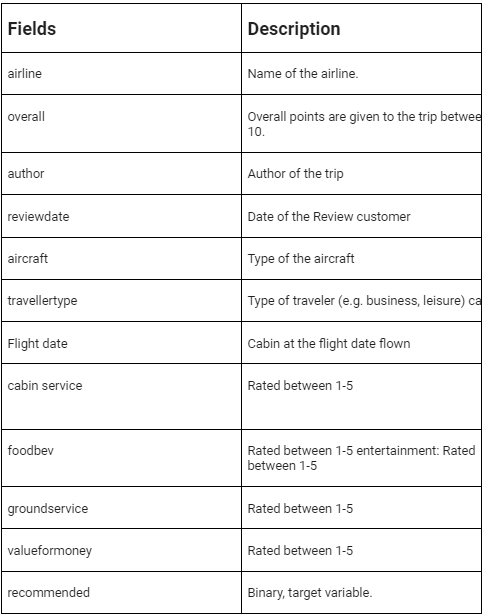

### Check Unique Values for each variable.

In [ ]:
# Check Unique Values for each variable.
for i in dataset.columns.tolist():
  print("No. of unique values in ",i,"is",dataset[i].nunique(),".")

## 3. ***Data Wrangling***

### Data Wrangling Code

In [ ]:
# remove rows with Null values
dataset.dropna(inplace=True)
dataset.info()

In [ ]:
# remove duplicates
dataset.drop_duplicates(inplace=True)
dataset.info()

In [ ]:
# Describe the stat

dataset.describe()

In [ ]:
dataset.head()

In [ ]:
# What are the categorical columns
categorical_columns = dataset.select_dtypes(include=['object']).columns.tolist()
print(categorical_columns)

In [ ]:
# Churn Counts grouby Traveller Type wise
pd.DataFrame(dataset.groupby('traveller_type')['recommended'].value_counts(  ).reset_index(name="Count"))

In [ ]:
# Convert rcommended column to Bool. If yes then 1 , if no then 0
dataset['recommended'] = np.where(dataset['recommended'] == 'yes', 1, 0)
dataset.info()

In [ ]:
# Plot cor-realtion among seat_comfort , cabin_service, food_bev, entertainment, ground_service, value_for_money and recommended
# Select the desired columns.
cols = ['overall','seat_comfort', 'cabin_service', 'food_bev', 'entertainment', 'ground_service', 'value_for_money', 'recommended']
df = dataset[cols]

# Calculate the correlation matrix.
corr = df.corr()

# Plot the heatmap.
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()



In [ ]:
new_dataset= dataset.copy(deep=True)
new_dataset.reset_index(drop=True, inplace=True)
new_dataset.info()

In [ ]:
# Convert categorical traveller_type and cabin data into One-Hot encoding
# Import the OneHotEncoder.
from sklearn.preprocessing import OneHotEncoder

# Create the encoder.
encoder = OneHotEncoder(handle_unknown='ignore')

# Fit the encoder on the categorical columns and transform them.
encoded_data = encoder.fit_transform(dataset[['traveller_type', 'cabin']]).toarray()

# Get the feature names.
feature_names = encoder.get_feature_names_out(['traveller_type', 'cabin'])
# add feature_names to dataframe
final_dataset = pd.concat([new_dataset, pd.DataFrame(encoded_data, columns=feature_names)], axis=1)
final_dataset.info()


## ***7. ML Model Implementation***

In [ ]:
# Generate Tarin and test data
X = final_dataset.drop(['recommended','airline','author','review_date','customer_review','aircraft','traveller_type','cabin','route','date_flown'], axis=1)
X.info()


In [ ]:
Y= final_dataset['recommended'].astype('int')
Y.info()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### ML Model - 1 - **Implementing Logistic Regression**

In [ ]:
# ML Model - 1 Implementation
clf = LogisticRegression(fit_intercept=True, max_iter=10000)
# Fit the Algorithm
clf.fit(X_train, y_train)

In [ ]:
# Checking the coefficients
clf.coef_

In [ ]:
# Checking the intercept value
clf.intercept_

In [ ]:
# Predict on the model
# Get the predicted probabilities
train_preds = clf.predict_proba(X_train)
test_preds = clf.predict_proba(X_test)

In [ ]:
# Get the predicted classes
train_class_preds = clf.predict(X_train)
test_class_preds = clf.predict(X_test)

In [ ]:
# Get the accuracy scores
train_accuracy = accuracy_score(train_class_preds,y_train)
test_accuracy = accuracy_score(test_class_preds,y_test)

print("The accuracy on train data is ", train_accuracy)
print("The accuracy on test data is ", test_accuracy)

#### 1. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

In [ ]:
# Visualizing evaluation Metric Score chart
# Get the confusion matrix for both train and test

labels = ['Recommended', 'Not-Recommended']
cm = confusion_matrix(y_train, train_class_preds)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
# Get the confusion matrix for both train and test

labels = ['Recommended', 'Not-Recommended']
cm = confusion_matrix(y_test, test_class_preds)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
print(metrics.classification_report(train_class_preds, y_train))
print(" ")

print("roc_auc_score")
print(metrics.roc_auc_score(y_train, train_class_preds))

In [ ]:
print(metrics.classification_report(test_class_preds, y_test))
print(" ")

print("roc_auc_score")
print(metrics.roc_auc_score(y_test, test_class_preds))

I used Logistic regression algorithm to create the model. As I got not so good result.


Next tryting to improving the score by using hyperparameter tuning technique.



#### 2. Cross- Validation & Hyperparameter Tuning

In [ ]:
# ML Model - 1 Implementation with hyperparameter optimization techniques (i.e., GridSearch CV, RandomSearch CV, Bayesian Optimization etc.)
model = LogisticRegression(max_iter=10000)
solvers = ['lbfgs']
penalty = ['10','l2','14','16','20','18']
c_values = [1000,100, 10, 1.0, 0.1, 0.01,0.001]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0)

# Fit the Algorithm
grid_result=grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


# Predict on the model
# Get the predicted classes
train_class_preds = grid_result.predict(X_train)
test_class_preds = grid_result.predict(X_test)

In [ ]:
print(metrics.classification_report(train_class_preds, y_train))
print(" ")

print("roc_auc_score")
print(metrics.roc_auc_score(y_train, train_class_preds))

In [ ]:
print(metrics.classification_report(test_class_preds, y_test))
print(" ")

print("roc_auc_score")
print(metrics.roc_auc_score(y_test, test_class_preds))

##### Which hyperparameter optimization technique have you used and why?

GridSearchCV which uses the Grid Search technique for finding the optimal hyperparameters to increase the model performance.

our goal should be to find the best hyperparameters values to get the perfect prediction results from our model.  But the question arises, how to find these best sets of hyperparameters? One can try the Manual Search method, by using the hit and trial process and can find the best hyperparameters which would take huge time to build a single model.

For this reason, methods like Random Search, GridSearch were introduced.
Grid Search uses a different combination of all the specified hyperparameters and their values and calculates the performance for each combination and selects the best value for the hyperparameters. This makes the processing time-consuming and expensive based on the number of hyperparameters involved.

In GridSearchCV, along with Grid Search, cross-validation is also performed. Cross-Validation is used while training the model.

That's why I have used GridsearCV method for hyperparameter optimization.

### ML Model - 2 - **Implementing XgBoost Classifier**

In [ ]:
# ML Model - 3 Implementation
# Create an instance of the RandomForestClassifier
xg_model = XGBClassifier()

# Fit the Algorithm
xg_models=xg_model.fit(X_train,y_train)

# Predict on the model
# Making predictions on train and test data

train_class_preds = xg_models.predict(X_train)
test_class_preds = xg_models.predict(X_test)

#### 1. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

In [ ]:
# Visualizing evaluation Metric Score chart
# Visualizing evaluation Metric Score chart# Get the confusion matrix for both train and test

labels = ['Recommended', 'Not-Recommended']
cm = confusion_matrix(y_train, train_class_preds)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
# Get the confusion matrix for both train and test

labels = ['Recommended', 'Non-Recommended']
cm = confusion_matrix(y_test, test_class_preds)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
print(metrics.classification_report(train_class_preds, y_train))
print(" ")

print("roc_auc_score")
print(metrics.roc_auc_score(y_train, train_class_preds))

In [ ]:
print(metrics.classification_report(test_class_preds, y_test))
print(" ")

print("roc_auc_score")
print(metrics.roc_auc_score(y_test, test_class_preds))

Then, I used XGBoost algorithm to create the model. As I got there  good result.


Next tryting to improving the score by using hyperparameter tuning technique.

In [ ]:
importances = xg_model.feature_importances_

importance_dict = {'Feature' : list(X_train.columns),
                   'Feature Importance' : importances}

importance_df = pd.DataFrame(importance_dict)
importance_df['Feature Importance'] = round(importance_df['Feature Importance'],2)

In [ ]:
importance_df.sort_values(by=['Feature Importance'],ascending=False)

In [ ]:
features = X_train.columns
importances = xg_model.feature_importances_
indices = np.argsort(importances)

In [ ]:
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='red', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

plt.show()

#### 2. Cross- Validation & Hyperparameter Tuning

In [ ]:
# ML Model - 3 Implementation with hyperparameter optimization techniques (i.e., GridSearch CV, RandomSearch CV, Bayesian Optimization etc.)
# Number of trees
n_estimators = [50,80,100]

# Maximum depth of trees
max_depth = [4,6,8]

# Minimum number of samples required to split a node
min_samples_split = [50,100,150]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40,50]

# HYperparameter Grid
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

# Create an instance of the RandomForestClassifier
xg_model = XGBClassifier()

# Fit the Algorithm
# Grid search
xg_grid = GridSearchCV(estimator=xg_model,
                       param_grid = param_dict,
                       cv = 5, verbose=2, scoring='roc_auc')

xg_grid1=xg_grid.fit(X_train,y_train)
# Predict on the model
# Making predictions on train and test data

train_class_preds = xg_grid1.predict(X_train)
test_class_preds = xg_grid1.predict(X_test)

In [ ]:
print("Best: %f using %s" % (xg_grid.best_score_, xg_grid.best_params_))

In [ ]:
# Visualizing evaluation Metric Score chart
# Visualizing evaluation Metric Score chart# Get the confusion matrix for both train and test

labels = ['Recommended', 'Not-recommended']
cm = confusion_matrix(y_train, train_class_preds)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
# Get the confusion matrix for both train and test

labels = ['Recommended', 'Non-recommended']
cm = confusion_matrix(y_test, test_class_preds)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
print(metrics.classification_report(train_class_preds, y_train))
print(" ")

print("roc_auc_score")
print(metrics.roc_auc_score(y_train, train_class_preds))

In [ ]:
print(metrics.classification_report(test_class_preds, y_test))
print(" ")

print("roc_auc_score")
print(metrics.roc_auc_score(y_test, test_class_preds))

##### Which hyperparameter optimization technique have you used and why?

GridSearchCV which uses the Grid Search technique for finding the optimal hyperparameters to increase the model performance.

our goal should be to find the best hyperparameters values to get the perfect prediction results from our model.  But the question arises, how to find these best sets of hyperparameters? One can try the Manual Search method, by using the hit and trial process and can find the best hyperparameters which would take huge time to build a single model.

For this reason, methods like Random Search, GridSearch were introduced.
Grid Search uses a different combination of all the specified hyperparameters and their values and calculates the performance for each combination and selects the best value for the hyperparameters. This makes the processing time-consuming and expensive based on the number of hyperparameters involved.

In GridSearchCV, along with Grid Search, cross-validation is also performed. Cross-Validation is used while training the model.

That's why I have used GridsearCV method for hyperparameter optimization.

### 2. Which ML model did you choose from the above created models as your final prediction model and why?

I have choosen XGBoost model which is hyperparameter optimized. first of all I need accuracy for the churn prediction and time isn't a constrain here, beacuse the data is not lke swiggy or ola which booking needs to be faster. Thus, for greater accuracy we used kernel SVM, Random Forest, XgBoost kind of ensembel r=techniques. So, I tried both Random Forest and XGBoost. Here is their ealuation metrics and I would like to compare.

https://medium.com/almabetter/data-preprocessing-ea09fac6a7f7

# **Conclusion**

Customer referrals are a powerful way to acquire new customers and build brand loyalty. Here are some strategies to improve customer referrals in an airline:

1. Offer a compelling referral program:
Simple and rewarding: Make the referral process easy and the rewards attractive.
Multiple rewards: Offer a variety of rewards, such as flight discounts, upgrades, or free checked bags, to cater to different preferences.
Track referrals: Use a referral tracking system to ensure that rewards are given out accurately.
2. Provide exceptional customer experiences:
Consistent quality: Ensure that customers receive consistent, high-quality service across all touchpoints, from booking to arrival.
Personalized service: Tailor the experience to individual needs and preferences.
Address complaints promptly: Resolve issues quickly and efficiently to maintain customer satisfaction.
3. Leverage social media:
Encourage sharing: Create shareable content, such as stunning destination photos or behind-the-scenes glimpses.
Engage with customers: Respond to comments and questions promptly and thoughtfully.
Run social media contests: Offer rewards for referrals or shares.
4. Partner with complementary businesses:
Co-branded promotions: Collaborate with hotels, car rental companies, or travel agencies to offer joint promotions.
Shared referral programs: Create a referral program that benefits both businesses.
5. Provide excellent customer support:
24/7 availability: Ensure that customer support is available around the clock.
Multiple channels: Offer support through phone, email, chat, and social media.
Empower agents: Give customer support agents the authority to resolve issues quickly and efficiently.
6. Recognize and reward loyal customers:
Loyalty programs: Offer tiered rewards for frequent flyers.
Personalized recognition: Acknowledge and thank loyal customers for their business.
Exclusive perks: Provide exclusive benefits, such as priority boarding or access to lounges.
By implementing these strategies, airlines can create a positive and memorable experience for their customers, encouraging them to refer their friends and family.


Use XGBoostClassifier model that is generated above to predict Customer Referral chances.

### ***Hurrah! You have successfully completed your Machine Learning Capstone Project !!!***